In [4]:
%matplotlib inline

import pymongo
import seaborn as sns

In [5]:
import pandas as pd

def group_by(df, bycols, agg_map):
    """

    @param df:      DataFrame
    @param bycols:  str or list
                        Column(s) to group by
    @param agg_map: dictionary or list of 2-tuples
                        Mapping from column to aggregate function e.g. [("city", "count"), ("salary", "mean"]
    @return:        DataFrame
                        Flattened dataframe, with multi-level index removed
    """
    grps = []
    if type(bycols) == str:
        bycols = [bycols]

    if type(agg_map) == dict:
        agg_map = agg_map.items()

    for k,v in agg_map:
        grp = df[bycols + [k]].groupby(bycols, ).agg(v)
        grp.reset_index(inplace=True)
        grp["%s(%s)" % (v,k)] = grp[k]
        del grp[k]
        grps.append(grp)

    m = grps[0]
    for grp in grps[1:]:
        m = pd.merge(m, grp, on=bycols, how="inner")
    return m

In [7]:
client = pymongo.MongoClient()
db = client.metrics_coref_new

cb_td, cb_vd, sc_td, sc_vd = "CB_TAGGING_TD_FEAT_SELECTION", "CB_TAGGING_VD_FEAT_SELECTION", \
    "SC_TAGGING_TD_FEAT_SELECTION", "SC_TAGGING_VD_FEAT_SELECTION",
cb_td, cb_vd, sc_td, sc_vd = db[cb_td], db[cb_vd], db[sc_td], db[sc_vd]
cb_td, cb_vd, sc_td, sc_vd

(Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_coref_new'), 'CB_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_coref_new'), 'CB_TAGGING_VD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_coref_new'), 'SC_TAGGING_TD_FEAT_SELECTION'),
 Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'metrics_coref_new'), 'SC_TAGGING_VD_FEAT_SELECTION'))

# Query Top Features

In [27]:
from pprint import pprint
from bson.son import SON # needed to ensure dictionary is ordered (python default is not)

feats_pipeline = [{
    "$project": { 
            "weighted_f1_score":"$WEIGHTED_MEAN_CONCEPT_CODES.f1_score",
            "micro_f1_score":  "$MICRO_F1.f1_score",
            "micro_recall":    "$MICRO_F1.recall",
            "micro_precision": "$MICRO_F1.precision",
            #"stemmed":        "$parameters.stemmed",
            #"num_feats":      "$parameters.num_feats_MEAN",
            "feats":          "$parameters.extractors",
            "count": {        "$size" : "$parameters.extractors" },
            "asof" :          "$asof",
            "_id":1
    }
},
{
    "$match":{
        "micro_f1_score": { "$exists" : True },
        # how many feats
        #"count": {          "$eq" :1 },
        # window width
        #"window_size": {    "$eq":13 }
    }
},
{
    "$sort":{
        #"weighted_f1_score":-1,
        "micro_f1_score": -1
        #"asof": -1
        #"count": -1
    }
},
]

cb_td_rows = [row for row in cb_td.aggregate(feats_pipeline)]
cb_vd_rows = [row for row in cb_vd.aggregate(feats_pipeline)]
sc_td_rows = [row for row in sc_td.aggregate(feats_pipeline)]
sc_vd_rows = [row for row in sc_vd.aggregate(feats_pipeline)]

print(len(cb_td_rows), len(cb_vd_rows), len(sc_td_rows), len(sc_vd_rows))

242 242 127 127


In [28]:
def hash_feats(fts):
    return "|".join(sorted(fts))

def get_df_sorted_by_f1score(rows):
    df = pd.DataFrame(rows).sort_values("micro_f1_score", ascending=False)
    df["hs_feats"] = df["feats"].apply(hash_feats)
    return df

cb_td_df = get_df_sorted_by_f1score(cb_td_rows)
cb_vd_df = get_df_sorted_by_f1score(cb_vd_rows)
sc_td_df = get_df_sorted_by_f1score(sc_td_rows)
sc_vd_df = get_df_sorted_by_f1score(sc_vd_rows)

cb_vd_df.head(3)

,_id,asof,count,feats,micro_f1_score,micro_precision,micro_recall,weighted_f1_score,hs_feats
0,5b594e509d1fa2c2325787b7,2018-07-25 23:30:08.857,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.299145,0.546875,0.205882,0.0,fn_bow_ngram_feat[ngram_size:1 offset:4]|fn_po...
1,5b59513c9d1fa2c2325787bf,2018-07-25 23:42:36.274,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.291845,0.539683,0.200000,0.0,fn_bow_ngram_feat[ngram_size:1 offset:4]|fn_bo...
2,5b594fc29d1fa2c2325787bb,2018-07-25 23:36:18.773,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.285714,0.500000,0.200000,0.0,fn_bow_POS_feats[offset:4]|fn_bow_ngram_feat[n...


In [29]:
min(cb_vd_df["asof"].values),max(cb_vd_df["asof"].values)

(numpy.datetime64('2018-07-25T21:24:55.611000000'),
 numpy.datetime64('2018-07-26T03:17:39.975000000'))

In [30]:
min(sc_vd_df["asof"].values),max(sc_vd_df["asof"].values)

(numpy.datetime64('2018-07-29T10:30:50.220000000'),
 numpy.datetime64('2018-07-29T13:45:38.542000000'))

In [33]:
cols = "feats,count,micro_f1_score,micro_recall,micro_precision".split(",")

def feat_name(ft):
    if type(ft) == list:
        ft=",".join(ft)
    offset = (11-1)/2
    offset_lbl = "offset:%i" % offset
    ft=ft.replace(offset_lbl, "").replace("fn_", "").replace(" ","")
    return ft

def get_top_individual_feats(df, stemmed=True):
    df_top_individual_feats = df[(df["count"] == 1)][cols]
    df_top_individual_feats["rank"] = np.arange(len(df_top_individual_feats)) + 1
    df_top_individual_feats["feats"] = df_top_individual_feats["feats"].apply(feat_name)
    return df_top_individual_feats

#get_top_individual_feats(cb_vd_df, False)

### Performance of Each Feature In Isolation

In [36]:
import numpy as np
stemmed = True
a, b = get_top_individual_feats(cb_vd_df, True), get_top_individual_feats(sc_vd_df, True)
# merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])\
# ["rank,feats_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,num_feats_CB,feats_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC,num_feats_SC".split(",")]
merged = pd.merge(a,b, on="rank", suffixes=["_CB","_SC"])
merged

,feats_CB,count_CB,micro_f1_score_CB,micro_recall_CB,micro_precision_CB,rank,feats_SC,count_SC,micro_f1_score_SC,micro_recall_SC,micro_precision_SC
0,pos_wd_feats_stemmed[offset:6],1,0.240000,0.150000,0.600000,1,pos_wd_feats[],1,0.244898,0.151579,0.637168
1,pos_wd_feats_stemmed[],1,0.239437,0.150000,0.593023,2,pos_wd_feats_stemmed[],1,0.243655,0.151579,0.620690
2,pos_wd_feats[offset:6],1,0.228571,0.141176,0.600000,3,pos_wd_feats_stemmed[offset:3],1,0.239168,0.145263,0.676471
3,pos_wd_feats_stemmed[offset:4],1,0.227603,0.138235,0.643836,4,pos_wd_feats_stemmed[offset:4],1,0.235094,0.145263,0.616071
4,pos_wd_feats[],1,0.224880,0.138235,0.602564,5,pos_wd_feats[offset:3],1,0.228471,0.136842,0.691489
5,pos_wd_feats[offset:4],1,0.220624,0.135294,0.597403,6,pos_wd_feats[offset:4],1,0.217993,0.132632,0.611650
6,pos_wd_feats_stemmed[offset:3],1,0.196078,0.117647,0.588235,7,pos_ngram_feat_stemmed[ngram_size:2],1,0.217082,0.128421,0.701149
7,pos_ngram_feat_stemmed[ngram_size:2offset:6],1,0.193069,0.114706,0.609375,8,pos_ngram_feat_stemmed[ngram_size:2offset:3],1,0.212996,0.124211,0.746835
8,pos_ngram_feat_stemmed[ngram_size:2],1,0.192593,0.114706,0.600000,9,pos_ngram_feat_stemmed[ngram_size:2offset:4],1,0.212766,0.126316,0.674157
9,pos_wd_feats_stemmed[offset:2],1,0.190955,0.111765,0.655172,10,pos_ngram_feat[ngram_size:2],1,0.211849,0.124211,0.719512


In [37]:
merged2=merged[["rank","feats_CB", "micro_f1_score_CB", "feats_SC", "micro_f1_score_SC"]].copy()
for c in merged2.columns:
    if "micro" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:.3f}".format(d) if type(d) == float else d)
    elif "num" in c:
        merged2[c]=merged2[c].apply(lambda d: "{0:,.1f}".format(d) if type(d) == float else d)
merged2

,rank,feats_CB,micro_f1_score_CB,feats_SC,micro_f1_score_SC
0,1,pos_wd_feats_stemmed[offset:6],0.240,pos_wd_feats[],0.245
1,2,pos_wd_feats_stemmed[],0.239,pos_wd_feats_stemmed[],0.244
2,3,pos_wd_feats[offset:6],0.229,pos_wd_feats_stemmed[offset:3],0.239
3,4,pos_wd_feats_stemmed[offset:4],0.228,pos_wd_feats_stemmed[offset:4],0.235
4,5,pos_wd_feats[],0.225,pos_wd_feats[offset:3],0.228
5,6,pos_wd_feats[offset:4],0.221,pos_wd_feats[offset:4],0.218
6,7,pos_wd_feats_stemmed[offset:3],0.196,pos_ngram_feat_stemmed[ngram_size:2],0.217
7,8,pos_ngram_feat_stemmed[ngram_size:2offset:6],0.193,pos_ngram_feat_stemmed[ngram_size:2offset:3],0.213
8,9,pos_ngram_feat_stemmed[ngram_size:2],0.193,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.213
9,10,pos_wd_feats_stemmed[offset:2],0.191,pos_ngram_feat[ngram_size:2],0.212


## Generate Rows for LaTex Table

In [38]:
def format_lbl(lbl):
    return lbl.replace("["," ").replace("]","").replace("_"," ").strip()

In [41]:
# for i, row in merged.iterrows():
#     feats_CB = format_lbl(row["feats_CB"])
#     micro_f1_score_CB = row["micro_f1_score_CB"]
    
#     feats_SC = format_lbl(row["feats_SC"])
#     micro_f1_score_SC = row["micro_f1_score_SC"]
    
#     print("{rank} & {feat_cb} & {cb_f1:0.3f} & & {feat_sc} & {sc_f1:0.3f}\\\\"\
#           .format(rank=i+1,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
#                   feat_sc=feats_SC, sc_f1=micro_f1_score_SC))


## Performance By Feature Set Size

In [42]:
def get_by_featureset_size(df):
    return group_by(df, bycols=["count"], agg_map=[("micro_f1_score", "max"),
                                              ("micro_f1_score", "mean"),
                                              #("micro_f1_score", "median"),
                                              #("micro_f1_score", "count"),
                                             ]).sort_values("count")

pd.merge(get_by_featureset_size(cb_vd_df), get_by_featureset_size(sc_vd_df), on="count", how="outer", suffixes=["_cb", "_sc"])

,count,max(micro_f1_score)_cb,mean(micro_f1_score)_cb,max(micro_f1_score)_sc,mean(micro_f1_score)_sc
0,1,0.240000,0.083476,0.244898,0.154870
1,2,0.276316,0.207128,0.272436,0.244784
2,3,0.273128,0.224627,0.280757,0.267228
3,4,0.285106,0.216923,0.283931,0.273170
4,5,0.299145,0.233628,0.287081,0.277399
5,6,0.291845,0.232259,0.283892,0.281845


# Get F1 Score By Num Features As the Optimal Feature Set is Constructed

In [45]:
#cols_filter = "count,new_feat,micro_f1_score,micro_recall,micro_precision,window_size".split(",")
cols_filter = "count,new_feat,micro_f1_score".split(",")

def get_f1_by_feat_count(df):
#     df=df[df["stemmed"] == True]
    top_feats = df[df["count"] == df["count"].max()]
    top_feats = top_feats.sort_values("micro_f1_score", ascending=False).iloc[0]["feats"]
    
    rows = []
    for i in range(0,len(top_feats)):
        new_feat = top_feats[i]
        upto = top_feats[:i+1]
        hs = hash_feats(upto)
        new_row = df[df["hs_feats"] == hs].iloc[0]
        new_row["new_feat"] = feat_name(new_feat)
        copy = {}
        for k in new_row.keys():
            copy[str(k).strip()] = new_row[k]
        rows.append(copy)

    df_f1_by_feat_count = pd.DataFrame(rows)
    return df_f1_by_feat_count[cols_filter]

df_f1_score_by_feat_size= pd.merge(get_f1_by_feat_count(cb_vd_df), get_f1_by_feat_count(sc_vd_df), on="count", how="outer", suffixes=("_CB", "_SC"))
##df_f1_score_by_feat_size
# Note that the optimal feature set for SC is only of size 4

#get_f1_by_feat_count(cb_vd_df)
#get_f1_by_feat_count(sc_vd_df)

df_f1_score_by_feat_size

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,pos_wd_feats_stemmed[offset:4],0.227603,pos_wd_feats_stemmed[offset:3],0.239168
1,2,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.249423,bow_ngram_feat[ngram_size:1offset:3],0.265574
2,3,pos_POS_feats[offset:4],0.269912,bow_POS_feats[offset:3],0.274194
3,4,bow_ngram_feat[ngram_size:1offset:4],0.285106,pos_ngram_feat_stemmed[ngram_size:2offset:3],0.283892
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.299145,pos_ngram_feat[ngram_size:3offset:3],0.287081
5,6,bow_ngram_feat[ngram_size:2offset:4],0.291845,pos_ngram_feat_stemmed[ngram_size:3offset:3],0.283892


In [48]:
# Round to 4 d.p. for printing
df = df_f1_score_by_feat_size["count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC".split(",")].copy()
df["micro_f1_score_CB"] = df["micro_f1_score_CB"].apply(lambda d: "{0:.4f}".format(d))
# df["num_feats_CB"]      = df["num_feats_CB"].apply(lambda d: "{0:,.1f}".format(d))
df["micro_f1_score_SC"] = df["micro_f1_score_SC"].apply(lambda d: "{0:.4f}".format(d))  
# df["num_feats_SC"]      = df["num_feats_SC"].apply(lambda d: "{0:,.1f}".format(d))
df

,count,new_feat_CB,micro_f1_score_CB,new_feat_SC,micro_f1_score_SC
0,1,pos_wd_feats_stemmed[offset:4],0.2276,pos_wd_feats_stemmed[offset:3],0.2392
1,2,pos_ngram_feat_stemmed[ngram_size:2offset:4],0.2494,bow_ngram_feat[ngram_size:1offset:3],0.2656
2,3,pos_POS_feats[offset:4],0.2699,bow_POS_feats[offset:3],0.2742
3,4,bow_ngram_feat[ngram_size:1offset:4],0.2851,pos_ngram_feat_stemmed[ngram_size:2offset:3],0.2839
4,5,pos_ngram_feat_stemmed[ngram_size:3offset:4],0.2991,pos_ngram_feat[ngram_size:3offset:3],0.2871
5,6,bow_ngram_feat[ngram_size:2offset:4],0.2918,pos_ngram_feat_stemmed[ngram_size:3offset:3],0.2839


# Plot F1 Score Against # Feature Sets

### Get the Max F1 Score for Each Size of Feature Set (Win = 9)

In [49]:
def get_max_f1_by_feat_count(df):
    max_feats = df["count"].values.max()
    rows = []
    for cnt in range(1, max_feats+1):
        
        row = df[df["count"] == cnt].sort_values("micro_f1_score", ascending=False).iloc[0]        
        rows.append(row)

    return pd.DataFrame(rows)

In [52]:
df_cb = get_max_f1_by_feat_count(cb_vd_df)[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
df_sc = get_max_f1_by_feat_count(sc_vd_df)[["count", "feats", "micro_f1_score", "micro_precision", "micro_recall"]]
by_feat_size = pd.merge(df_cb, df_sc, on="count", how="outer", suffixes=["_CB", "_SC"])
by_feat_size

,count,feats_CB,micro_f1_score_CB,micro_precision_CB,micro_recall_CB,feats_SC,micro_f1_score_SC,micro_precision_SC,micro_recall_SC
0,1,[fn_pos_wd_feats_stemmed[offset:6]],0.240000,0.600000,0.150000,[fn_pos_wd_feats[offset:5]],0.244898,0.637168,0.151579
1,2,"[fn_pos_wd_feats_stemmed[offset:5], fn_bow_ngr...",0.276316,0.543103,0.185294,"[fn_pos_wd_feats_stemmed[offset:4], fn_bow_ngr...",0.272436,0.570470,0.178947
2,3,"[fn_pos_wd_feats_stemmed[offset:5], fn_bow_ngr...",0.273128,0.543860,0.182353,"[fn_pos_wd_feats_stemmed[offset:4], fn_bow_ngr...",0.280757,0.559748,0.187368
3,4,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.285106,0.515385,0.197059,"[fn_pos_wd_feats_stemmed[offset:4], fn_bow_ngr...",0.283931,0.548193,0.191579
4,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.299145,0.546875,0.205882,"[fn_pos_wd_feats_stemmed[offset:3], fn_bow_ngr...",0.287081,0.592105,0.189474
5,6,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.291845,0.539683,0.200000,"[fn_pos_wd_feats_stemmed[offset:3], fn_bow_ngr...",0.283892,0.585526,0.187368


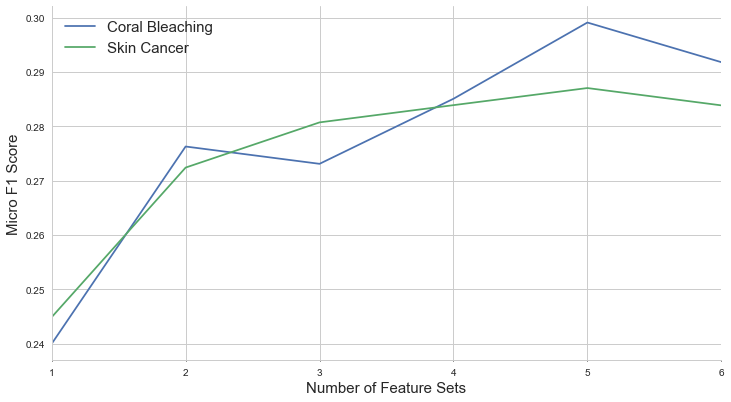

In [55]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 15

df = by_feat_size

STYLE = "whitegrid"
sns.set_style(STYLE)
sns.set_style(STYLE, {"xtick.major.size": 1})

fig = plt.figure(figsize=(12,6.5))

x = df["count"].values
y_cb = df["micro_f1_score_CB"].values
y_sc = df["micro_f1_score_SC"].values

ax1 = fig.add_subplot(111)
ax1.plot(x,y_cb, label="Coral Bleaching")
ax1.plot(x,y_sc, label="Skin Cancer")

legend = ax1.legend(loc='upper left', shadow=True, fontsize=FONT_SIZE)

ax1.set_xlim([1, 6])
#ax1.set_ylim([0.695, 0.77])
ax1.set_xlabel('Number of Feature Sets', fontsize=FONT_SIZE)
ax1.set_ylabel('Micro F1 Score', fontsize=FONT_SIZE)

plt.xticks(np.arange(min(x), max(x)+1, 1.0), fontsize=10)
sns.despine()

# plt.savefig("/Users/simon.hughes/BitBucket/Dissertation/Dissertation/images/sr_parser_f1_score_by_num_feats.png")
# plt.show()

## Generate Rows for LaTex Table

### F1 Score As Individual Features are Added

In [56]:
for i, row in df_f1_score_by_feat_size.iterrows():
    #pprint(row)
    
    feats_CB = format_lbl(row["new_feat_CB"])
    micro_f1_score_CB = row["micro_f1_score_CB"]
    
    feats_SC = format_lbl(str(row["new_feat_SC"]))
    if feats_SC == "nan":
        feats_SC = "-"
        
    micro_f1_score_SC = row["micro_f1_score_SC"]
    if str(micro_f1_score_SC) != "nan":
        micro_f1_score_SC = "{0:0.4f}".format(micro_f1_score_SC)
    else:
        micro_f1_score_SC = "-"
    count = row["count"]
    print("{count} & {feat_cb} & {cb_f1:0.4f} & & {feat_sc} & {sc_f1}\\\\"\
          .format(count=count,feat_cb=feats_CB, cb_f1=micro_f1_score_CB,
                  feat_sc=feats_SC, sc_f1=micro_f1_score_SC))

1 & pos wd feats stemmed offset:4 & 0.2276 & & pos wd feats stemmed offset:3 & 0.2392\\
2 & pos ngram feat stemmed ngram size:2offset:4 & 0.2494 & & bow ngram feat ngram size:1offset:3 & 0.2656\\
3 & pos POS feats offset:4 & 0.2699 & & bow POS feats offset:3 & 0.2742\\
4 & bow ngram feat ngram size:1offset:4 & 0.2851 & & pos ngram feat stemmed ngram size:2offset:3 & 0.2839\\
5 & pos ngram feat stemmed ngram size:3offset:4 & 0.2991 & & pos ngram feat ngram size:3offset:3 & 0.2871\\
6 & bow ngram feat ngram size:2offset:4 & 0.2918 & & pos ngram feat stemmed ngram size:3offset:3 & 0.2839\\


## Sanity Check - Do Any Datasets have Duplicate Feature Sets with Different F1 Scores?

In [58]:
#SH: There were some issues with the CB_VD dataset initially for a couple of collections
for df in [cb_td_df, cb_vd_df, sc_td_df, sc_vd_df]:
    gb = group_by(df, bycols=["hs_feats"], agg_map=[
        ("micro_f1_score", "count"),
        ("micro_f1_score", "min"),
        ("micro_f1_score", "max"),
    ])
    gb = gb[gb["count(micro_f1_score)"] > 1]
    miss_match = gb[gb["min(micro_f1_score)"] != gb["max(micro_f1_score)"]]
    
    assert len(miss_match) == 0, "Some errors occurred during data capture"

### Compute Reduction in Features

In [185]:
# df = cb_vd_df
# best_row = df.sort_values("micro_f1_score").tail(1)

# max_feats = best_row["count"].values[0]

# sub = df[df["count"] == max_feats-1].sort_values("micro_f1_score")
# feats = sub.tail(1)["feats"].values[0]
# num_feats = sub.tail(1)["num_feats"].values[0]

# max_ft_df = (df[df["count"] == max_feats]).copy()
# max_ft_df["diff"] = max_ft_df["num_feats"] - num_feats
# diffs = max_ft_df["diff"].sum()
# total_feats = diffs + num_feats
# # diffs, total_feats
# act_feats = best_row["num_feats"].values[0]
# act_feats,total_feats, act_feats/total_feats

(33944.0, 123452.0, 0.2749570683342514)

In [60]:
# df = sc_vd_df
# best_row = df.sort_values("micro_f1_score").tail(1)

# max_feats = df["count"].max()

# sub = df[df["count"] == max_feats-1].sort_values("micro_f1_score")
# #feats = sub.tail(1)["feats"].values[0]
# num_feats = sub.tail(1)["num_feats"].values[0]

# max_ft_df = (df[df["count"] == max_feats]).copy()
# max_ft_df["diff"] = max_ft_df["num_feats"] - num_feats
# diffs = max_ft_df["diff"].sum()
# total_feats = diffs + num_feats
# # diffs, total_feats
# act_feats = best_row["num_feats"].values[0]
# act_feats,total_feats,act_feats/total_feats

## List the Optimal Feat Set

In [71]:
cb_vd_df.sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
0,5,"[fn_pos_wd_feats_stemmed[offset:4], fn_pos_ngr...",0.299145,0.546875,0.205882


In [72]:
cb_vd_df.sort_values("micro_f1_score", ascending=False).head(1)["feats"].values[0]

['fn_pos_wd_feats_stemmed[offset:4]',
 'fn_pos_ngram_feat_stemmed[ngram_size:2 offset:4]',
 'fn_pos_POS_feats[offset:4]',
 'fn_bow_ngram_feat[ngram_size:1 offset:4]',
 'fn_pos_ngram_feat_stemmed[ngram_size:3 offset:4]']

In [73]:
sc_vd_df.sort_values("micro_f1_score", ascending=False).head(1)\
[["count","feats","micro_f1_score","micro_precision","micro_recall"]]

,count,feats,micro_f1_score,micro_precision,micro_recall
0,5,"[fn_pos_wd_feats_stemmed[offset:3], fn_bow_ngr...",0.287081,0.592105,0.189474


In [74]:
sc_vd_df.sort_values("micro_f1_score", ascending=False).head(1)["feats"].values[0]

['fn_pos_wd_feats_stemmed[offset:3]',
 'fn_bow_ngram_feat[ngram_size:1 offset:3]',
 'fn_bow_POS_feats[offset:3]',
 'fn_pos_ngram_feat_stemmed[ngram_size:2 offset:3]',
 'fn_pos_ngram_feat[ngram_size:3 offset:3]']